In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
data = pd.read_csv('diabetes.csv')
data

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [ ]:
pd.Series(data.columns, name = 'Columns')

0          Diabetes_binary
1                   HighBP
2                 HighChol
3                CholCheck
4                      BMI
5                   Smoker
6                   Stroke
7     HeartDiseaseorAttack
8             PhysActivity
9                   Fruits
10                 Veggies
11       HvyAlcoholConsump
12           AnyHealthcare
13             NoDocbcCost
14                 GenHlth
15                MentHlth
16                PhysHlth
17                DiffWalk
18                     Sex
19                     Age
20               Education
21                  Income
Name: Columns, dtype: object

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [ ]:
print(f'Количество пропущенных значений: {data.isna().sum().sum()}')

Количество пропущенных значений: 0


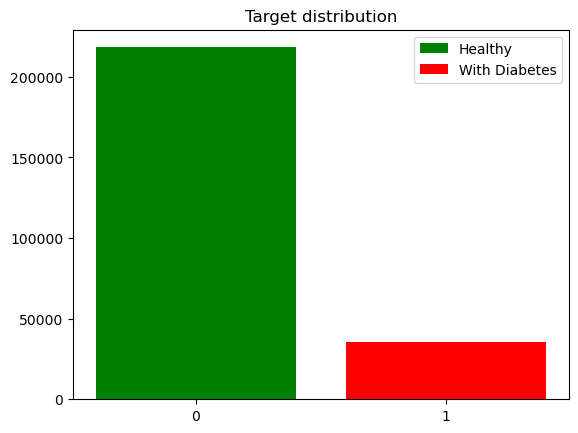

In [ ]:
healthy = data['Diabetes_binary'].value_counts()[0]
ill = data['Diabetes_binary'].value_counts()[1]
plt.bar('0', healthy, color= 'green')
plt.bar('1', ill, color= 'red')
plt.legend(['Healthy','With Diabetes'])
plt.title('Target distribution')
plt.show()

In [ ]:
def find_thresh(model, X_val, y_val):
  y_probs = model.predict_proba(X_val)[:, 1]

  thresholds = np.linspace(0.01, 0.99, 100)
  f1_scores = [f1_score(y_val, y_probs > t) for t in thresholds]

  best_thresh = thresholds[np.argmax(f1_scores)]
  best_f1 = max(f1_scores)

  print(f"Лучший порог: {best_thresh:.3f}, F1-score: {best_f1:.4f}")
  return best_thresh


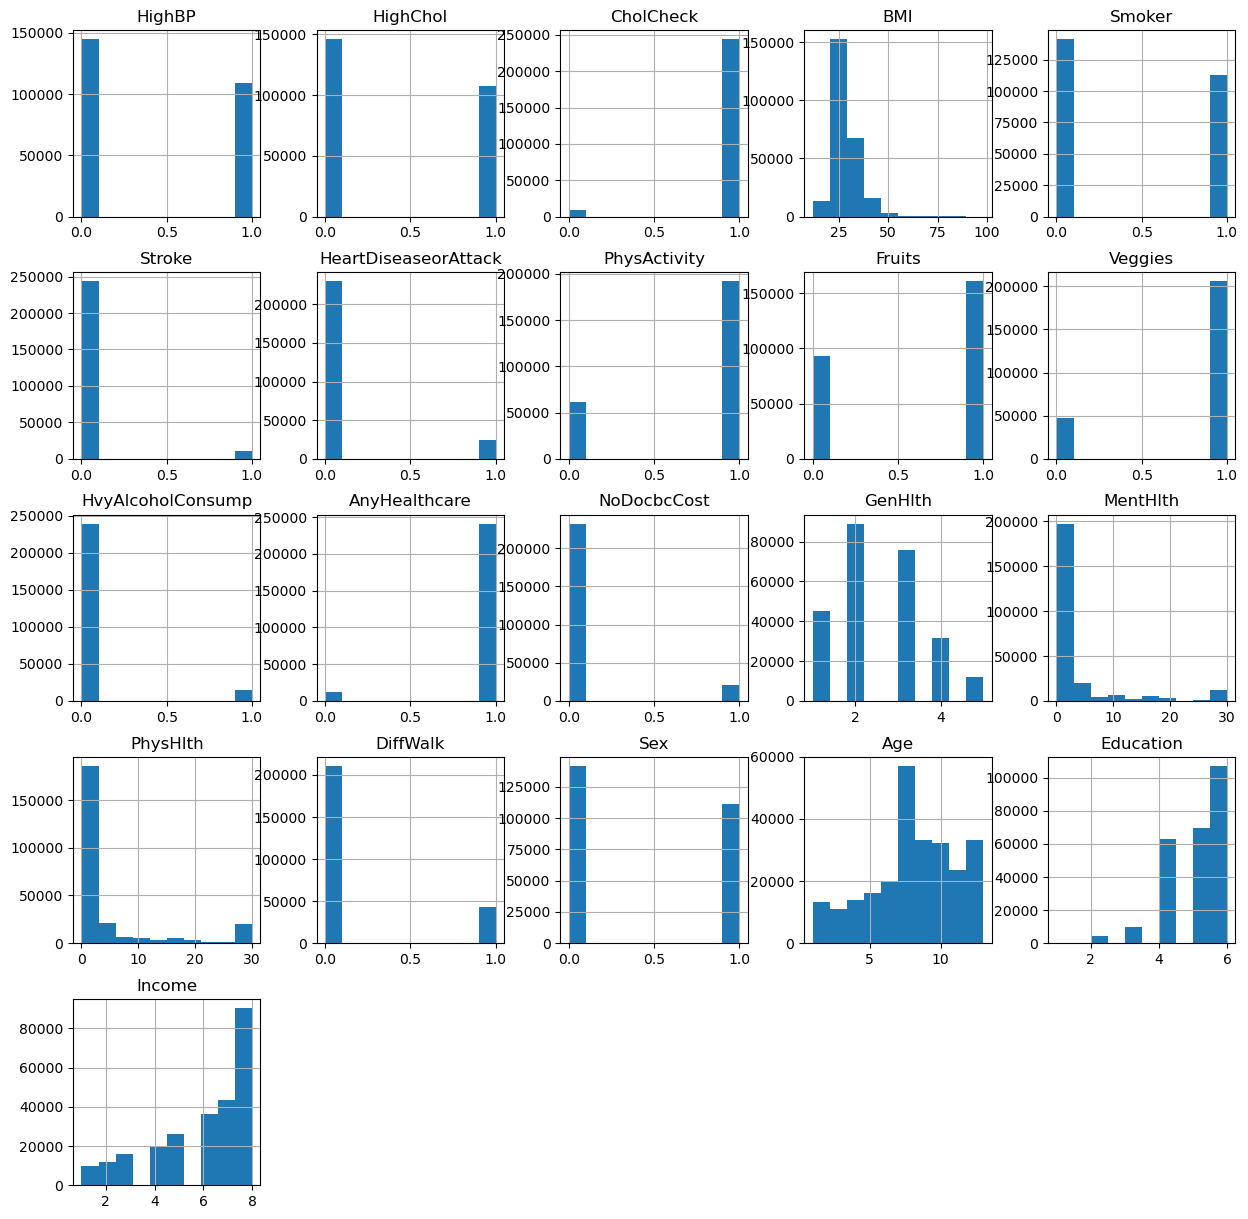

In [ ]:
data.drop('Diabetes_binary',axis=1).hist(figsize=(15,15))
plt.show()

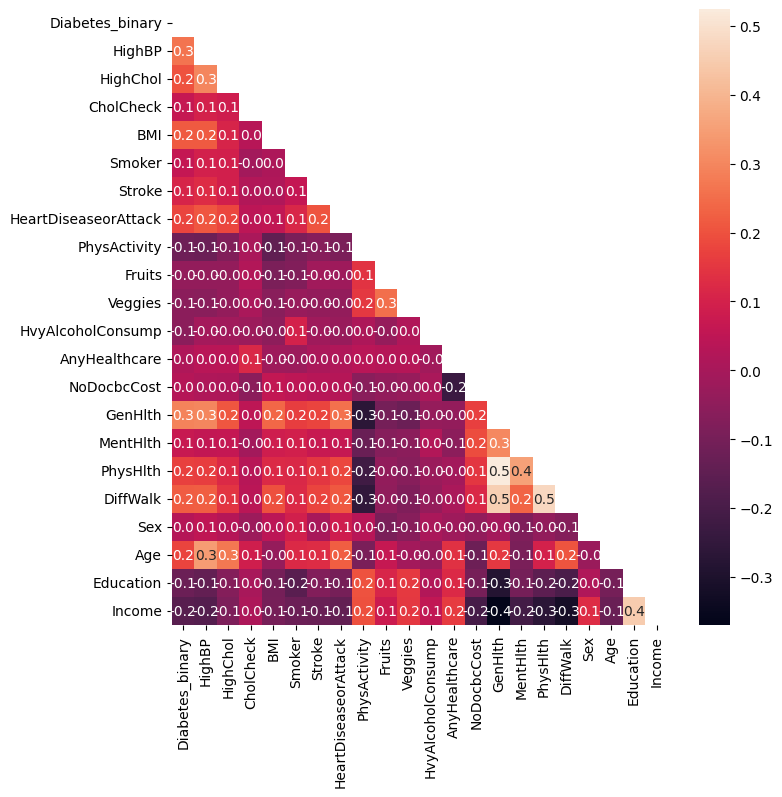

In [ ]:
corr_matrix = data.corr(numeric_only=True)

plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, annot=True, mask = np.triu(corr_matrix), fmt='.1f')
plt.show()

In [ ]:
high_corr = corr_matrix['Diabetes_binary'][abs(corr_matrix['Diabetes_binary']) >=0.2]
print(f'Большая корреляция с целевой переменной у признаков:\n{list(high_corr.index)}')

Большая корреляция с целевой переменной у признаков:
['Diabetes_binary', 'HighBP', 'HighChol', 'BMI', 'GenHlth', 'DiffWalk']


In [ ]:
results = pd.DataFrame(index=['Accuracy(train)', 'F1(train)', 'ROC-AUC(train)', 'Accuracy(val)', 'F1(val)', 'ROC-AUC(val)', 'Accuracy(test)', 'F1(test)', 'ROC-AUC(test)'],
                       columns=['NeuralNetwork', 'Logistic Regression', 'Decision Tree', 'Decision Tree (CV)', 'Random Forest (CV)', 'LightGBM', 'LightGBM (CV)'])
results

,NeuralNetwork,Logistic Regression,Decision Tree,Decision Tree (CV),Random Forest (CV),LightGBM,LightGBM (CV)
Accuracy(train),NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1(train),NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROC-AUC(train),NaN,NaN,NaN,NaN,NaN,NaN,NaN
Accuracy(val),NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1(val),NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROC-AUC(val),NaN,NaN,NaN,NaN,NaN,NaN,NaN
Accuracy(test),NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1(test),NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROC-AUC(test),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X = data.drop('Diabetes_binary', axis=1)
y = data['Diabetes_binary']

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X,y, test_size=0.1, stratify=y, random_state=2004)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=2004)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# NN


In [4]:
class Data(Dataset):
  def __init__(self, data):
    self.data = data
    self.X = torch.tensor(self.data.drop('Diabetes_binary', axis=1).values, dtype= torch.float32)
    self.y = torch.tensor(self.data['Diabetes_binary'].values, dtype= torch.float32)



  def __len__(self):
    return len(self.X)


  def __getitem__(self, index):
    return self.X[index], self.y[index]


In [5]:
dataset = Data(data)

In [6]:
train, val, test = random_split(dataset, [0.7, 0.2, 0.1])

In [7]:
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

In [8]:
for x,y in train_loader:
  print(f'sample: {x.shape} \n target: {y.shape}')
  break

sample: torch.Size([64, 21]) 
 target: torch.Size([64])


In [9]:
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.fc = nn.Sequential(

            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,output_size)


    )

  def forward(self, x):
    return self.fc(x)

In [10]:
input_size = 21
hidden_size = 64
output_size = 2


net = Net(input_size, hidden_size, output_size).to(device)
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), 0.0001)

def train_model(model, train_loader, val_loader, loss_mod, opt, epochs = 20):
  train_loss = []
  train_acc = []

  val_loss = []
  val_acc = []

  for epoch in range(epochs):
    train_loop = tqdm(train_loader)
    running_train_loss = []
    running_train_acc = []

    model.train()
    for x, y in train_loop:
      x = x.to(torch.float32).to(device)
      y = y.to(torch.long).to(device)

      pred = model(x)
      loss = loss_mod(pred, y)

      opt.zero_grad()
      loss.backward()
      opt.step()

      running_train_loss.append(loss.item())
      mean_loss = sum(running_train_loss) / len(running_train_loss)

      pred_labels = torch.argmax(pred, dim=1)
      correct = (pred_labels == y).sum().item()
      acc = correct / y.size(0)
      running_train_acc.append(acc)
      mean_acc = sum(running_train_acc) / len(running_train_acc)

      train_loop.set_description(f'Epoch: {epoch+1}/{epochs} mean loss: {mean_loss:.4f} acc: {mean_acc:.4f}')

    train_loss.append(mean_loss)
    train_acc.append(mean_acc)

    val_loop = tqdm(val_loader)
    running_val_loss = []
    running_val_acc = []

    with torch.no_grad():
      model.eval()
      for x, y in val_loop:
        x = x.to(torch.float32).to(device)
        y = y.to(torch.long).to(device)

        pred = model(x)
        loss = loss_mod(pred, y)

        running_val_loss.append(loss.item())
        mean_loss = sum(running_val_loss) / len(running_val_loss)

        pred_labels = torch.argmax(pred, dim=1)
        correct = (pred_labels == y).sum().item()
        acc = correct / y.size(0)
        running_val_acc.append(acc)
        mean_acc = sum(running_val_acc) / len(running_val_acc)

        val_loop.set_description(f'   Epoch: {epoch+1}/{epochs} mean loss: {mean_loss:.4f} acc: {mean_acc:.4f}')

    val_loss.append(mean_loss)
    val_acc.append(mean_acc)

  return train_loss, train_acc, val_loss, val_acc

train_loss, train_acc, val_loss, val_acc = train_model(net, train_loader, val_loader, loss, opt)

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

  0%|          | 0/2775 [00:00<?, ?it/s]

  0%|          | 0/793 [00:00<?, ?it/s]

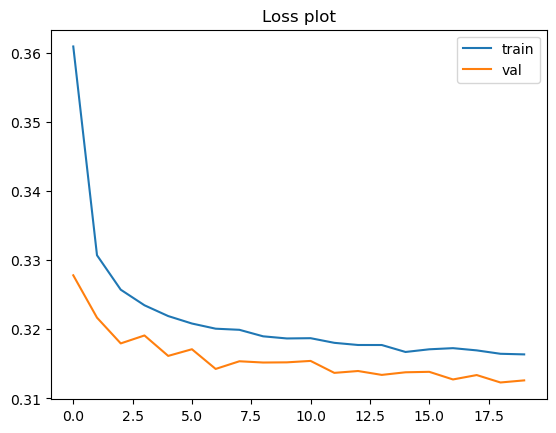

In [ ]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train', 'val'])
plt.title('Loss plot')
plt.show()

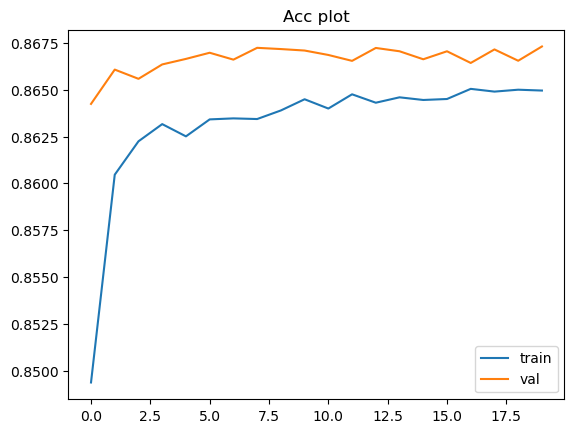

In [ ]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train', 'val'])
plt.title('Acc plot')
plt.show()

In [ ]:
from torch.nn.functional import softmax

net.eval()
net_pred_train = []
net_proba_train = []
y_train_n = []

net_pred_val = []
net_proba_val = []
y_val_n = []

net_pred_test = []
net_proba_test = []
y_test_n = []
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        out = net(X_batch)
        preds = out.argmax(dim=1)
        probs = softmax(out, dim=1)

        net_proba_train.extend(probs[:, 1].cpu().numpy())
        net_pred_train.extend(preds.cpu().numpy())
        y_train_n.extend(y_batch.cpu().numpy())

    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        out = net(X_batch)
        preds = out.argmax(dim=1)
        probs = softmax(out, dim=1)

        net_proba_val.extend(probs[:, 1].cpu().numpy())
        net_pred_val.extend(preds.cpu().numpy())
        y_val_n.extend(y_batch.cpu().numpy())

    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        out = net(X_batch)
        preds = out.argmax(dim=1)
        probs = softmax(out, dim=1)

        net_proba_test.extend(probs[:, 1].cpu().numpy())
        net_pred_test.extend(preds.cpu().numpy())
        y_test_n.extend(y_batch.cpu().numpy())




In [ ]:
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_val_n, np.array(net_proba_val) > t) for t in thresholds]

idx = np.argmax(f1_scores)
thresh = thresholds[idx]


net_acc_train = accuracy_score(y_train_n, net_pred_train)
net_f1_score_train = f1_score(y_train_n, (np.array(net_proba_train) > thresh).astype(int))
net_roc_train = roc_auc_score(y_train_n, net_proba_train)

net_acc_val = accuracy_score(y_val_n, net_pred_val)
net_f1_score_val = f1_score(y_val_n, (np.array(net_proba_val) > thresh).astype(int))
net_roc_val = roc_auc_score(y_val_n, net_proba_val)

print(f'Метрики Нейросети на тренировочных данных:\n'
f'Accuracy: {net_acc_train:.4f}\n'
f'F1-score: {net_f1_score_train:.4f}\n'
f'ROC-AUC: {net_roc_train:.4f}\n'
f'Метрики Нейросети на валидационных данных:\n'
f'Accuracy: {net_acc_val:.4f}\n'
f'F1-score: {net_f1_score_val:.4f}\n'
f'ROC-AUC: {net_roc_val:.4f}')

Метрики Нейросети на тренировочных данных:
Accuracy: 0.8667
F1-score: 0.4713
ROC-AUC: 0.8312
Метрики Нейросети на валидационных данных:
Accuracy: 0.8673
F1-score: 0.4737
ROC-AUC: 0.8298


In [ ]:
net_acc_test = accuracy_score(y_test_n, net_pred_test)
net_f1_score_test = f1_score(y_test_n, (np.array(net_proba_test) > thresh).astype(int))
net_roc_test = roc_auc_score(y_test_n, net_proba_test)

print(f'Метрики Нейросети на тестовых данных:\n'
f'Accuracy: {net_acc_test:.4f}\n'
f'F1-score: {net_f1_score_test:.4f}\n'
f'ROC-AUC: {net_roc_test:.4f}\n')

results['NeuralNetwork'] = [net_acc_train, net_f1_score_train, net_roc_train, net_acc_val, net_f1_score_val, net_roc_val, net_acc_test, net_f1_score_test, net_roc_test]

Метрики Нейросети на тестовых данных:
Accuracy: 0.8655
F1-score: 0.4727
ROC-AUC: 0.8315



# Log reg


In [ ]:
log_reg = LogisticRegression(penalty='l2', solver='liblinear').fit(X_train_scaled, y_train)

In [ ]:
log_reg = log_reg.fit(X_train_scaled, y_train)

In [ ]:
lr_t = find_thresh(log_reg, X_val_scaled, y_val)

lr_pred_train = log_reg.predict(X_train_scaled)
lr_acc_train = accuracy_score(y_train, lr_pred_train)
lr_f1_score_train = f1_score(y_train, (log_reg.predict_proba(X_train_scaled)[:,1]>lr_t))
lr_roc_train = roc_auc_score(y_train, log_reg.predict_proba(X_train_scaled)[:,1])

lr_pred_val = log_reg.predict(X_val_scaled)
lr_acc_val = accuracy_score(y_val, lr_pred_val)
lr_f1_score_val = f1_score(y_val, (log_reg.predict_proba(X_val_scaled)[:,1]>lr_t))
lr_roc_val = roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:,1])

print(f'Метрики Логистической регрессии на тренировочных данных:\n'
f'Accuracy: {lr_acc_train:.4f}\n'
f'F1-score: {lr_f1_score_train:.4f}\n'
f'ROC-AUC: {lr_roc_train:.4f}\n'
f'Метрики Логистической регрессии на валидационных данных:\n'
f'Accuracy: {lr_acc_val:.4f}\n'
f'F1-score: {lr_f1_score_val:.4f}\n'
f'ROC-AUC: {lr_roc_val:.4f}')

Лучший порог: 0.198, F1-score: 0.4604
Метрики Логистической регрессии на тренировочных данных:
Accuracy: 0.8638
F1-score: 0.4595
ROC-AUC: 0.8222
Метрики Логистической регрессии на валидационных данных:
Accuracy: 0.8624
F1-score: 0.4604
ROC-AUC: 0.8218


In [ ]:
lr_pred_test = log_reg.predict(X_test_scaled)
lr_acc_test = accuracy_score(y_test, lr_pred_test)
lr_f1_score_test = f1_score(y_test, (log_reg.predict_proba(X_test_scaled)[:,1]>lr_t))
lr_roc_test = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:,1])

print(f'Метрики Логистической регрессии на тестовых данных:\n'
f'Accuracy: {lr_acc_test:.4f}\n'
f'F1-score: {lr_f1_score_test:.4f}\n'
f'ROC-AUC: {lr_roc_test:.4f}\n')

results['Logistic Regression'] = [lr_acc_train, lr_f1_score_train, lr_roc_train, lr_acc_val, lr_f1_score_val, lr_roc_val, lr_acc_test, lr_f1_score_test, lr_roc_test]

Метрики Логистической регрессии на тестовых данных:
Accuracy: 0.8640
F1-score: 0.4603
ROC-AUC: 0.8208



# Dec Tree

In [ ]:
dt = DecisionTreeClassifier().fit(X_train_scaled,y_train)

In [ ]:
dt_t = find_thresh(dt, X_val_scaled, y_val)

dt_pred_train = dt.predict(X_train_scaled)
dt_acc_train = accuracy_score(y_train,dt_pred_train)
dt_f1_score_train = f1_score(y_train, (dt.predict_proba(X_train_scaled)[:,1]>dt_t))
dt_roc_train = roc_auc_score(y_train, dt.predict_proba(X_train_scaled)[:,1])

dt_pred_val = dt.predict(X_val_scaled)
dt_acc_val = accuracy_score(y_val, dt_pred_val)
dt_f1_score_val = f1_score(y_val, (dt.predict_proba(X_val_scaled)[:,1]>dt_t))
dt_roc_val = roc_auc_score(y_val, dt.predict_proba(X_val_scaled)[:,1])

print(f'Метрики Решающего Дерева на тренировочных данных:\n'
f'Accuracy: {dt_acc_train:.4f}\n'
f'F1-score: {dt_f1_score_train:.4f}\n'
f'ROC-AUC: {dt_roc_train:.4f}\n'
f'Метрики Решающего дерева на валидационных данных:\n'
f'Accuracy: {dt_acc_val:.4f}\n'
f'F1-score: {dt_f1_score_val:.4f}\n'
f'ROC-AUC: {dt_roc_val:.4f}')

Лучший порог: 0.406, F1-score: 0.2987
Метрики Решающего Дерева на тренировочных данных:
Accuracy: 0.9947
F1-score: 0.9812
ROC-AUC: 0.9999
Метрики Решающего дерева на валидационных данных:
Accuracy: 0.7950
F1-score: 0.2987
ROC-AUC: 0.5922


In [ ]:
dt_pred_test = dt.predict(X_test_scaled)
dt_acc_test = accuracy_score(y_test, dt_pred_test)
dt_f1_score_test = f1_score(y_test, (dt.predict_proba(X_test_scaled)[:,1]>dt_t))
dt_roc_test = roc_auc_score(y_test, dt.predict_proba(X_test_scaled)[:,1])

print(f'Метрики Решающего Дерева на тестовых данных:\n'
f'Accuracy: {dt_acc_test:.4f}\n'
f'F1-score: {dt_f1_score_test:.4f}\n'
f'ROC-AUC: {dt_roc_test:.4f}\n')

results['Decision Tree'] = [dt_acc_train, dt_f1_score_train, dt_roc_train, dt_acc_val, dt_f1_score_val, dt_roc_val, dt_acc_test, dt_f1_score_test, dt_roc_test]

Метрики Решающего Дерева на тестовых данных:
Accuracy: 0.7977
F1-score: 0.3062
ROC-AUC: 0.5980



# Dec Tree + CV

In [ ]:
params = {
    'max_depth' : [20,30,40,50, None],
    'min_samples_split' : [10,20,30],
    'min_samples_leaf' : [2,5,10],
    'criterion' : ['gini', 'entropy'],
    'class_weight' : [None, 'balanced'],
    'splitter' : ['best', 'random']
}

In [ ]:
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=2004),
                           params, cv=5, scoring='f1')

In [ ]:
grid_search.fit(X_train_scaled, y_train)
print(f'Лучшие параметры для Дерева: \n{grid_search.best_params_}')

Лучшие параметры для Дерева: 
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 30, 'splitter': 'random'}


In [ ]:
best_dt = grid_search.best_estimator_

In [ ]:
best_dt_t = find_thresh(best_dt, X_val_scaled, y_val)

best_dt_pred_train = best_dt.predict(X_train_scaled)
best_dt_acc_train = accuracy_score(y_train, best_dt_pred_train)
best_dt_f1_score_train = f1_score(y_train, (best_dt.predict_proba(X_train_scaled)[:,1]>best_dt_t))
best_dt_roc_train = roc_auc_score(y_train, best_dt.predict_proba(X_train_scaled)[:,1])

best_dt_pred_val = best_dt.predict(X_val_scaled)
best_dt_acc_val = accuracy_score(y_val, best_dt_pred_val)
best_dt_f1_score_val = f1_score(y_val, (best_dt.predict_proba(X_val_scaled)[:,1]>best_dt_t))
best_dt_roc_val = roc_auc_score(y_val, best_dt.predict_proba(X_val_scaled)[:,1])

print(f'Метрики Решающего Дерева на тренировочных данных после кросс-валидации:\n'
f'Accuracy: {best_dt_acc_train:.4f}\n'
f'F1-score: {best_dt_f1_score_train:.4f}\n'
f'ROC-AUC: {best_dt_roc_train:.4f}\n'
f'Метрики Решающего дерева на валидационных данных после кросс валидации:\n'
f'Accuracy: {best_dt_acc_val:.4f}\n'
f'F1-score: {best_dt_f1_score_val:.4f}\n'
f'ROC-AUC: {best_dt_roc_val:.4f}')

Лучший порог: 0.604, F1-score: 0.4130
Метрики Решающего Дерева на тренировочных данных после кросс-валидации:
Accuracy: 0.7547
F1-score: 0.5267
ROC-AUC: 0.8854
Метрики Решающего дерева на валидационных данных после кросс валидации:
Accuracy: 0.7114
F1-score: 0.4130
ROC-AUC: 0.7616


In [ ]:
best_dt_pred_test = best_dt.predict(X_test_scaled)
best_dt_acc_test = accuracy_score(y_test, best_dt_pred_test)
best_dt_f1_score_test = f1_score(y_test, (best_dt.predict_proba(X_test_scaled)[:,1]>best_dt_t))
best_dt_roc_test = roc_auc_score(y_test, best_dt.predict_proba(X_test_scaled)[:,1])

print(f'Метрики Решающего Дерева на тестовых данных после кросс-валидации:\n'
f'Accuracy: {best_dt_acc_test:.4f}\n'
f'F1-score: {best_dt_f1_score_test:.4f}\n'
f'ROC-AUC: {best_dt_roc_test:.4f}\n')

results['Decision Tree (CV)'] = [best_dt_acc_train, best_dt_f1_score_train, best_dt_roc_train, best_dt_acc_val, best_dt_f1_score_val, best_dt_roc_val, best_dt_acc_test, best_dt_f1_score_test, best_dt_roc_test]

Метрики Решающего Дерева на тестовых данных после кросс-валидации:
Accuracy: 0.7067
F1-score: 0.4172
ROC-AUC: 0.7609



#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
params = {
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'n_estimators' : [50, 70, 100, 120],
    'max_features' : ['sqrt', 'log2', None],
    'class_weight' : ['balanced'],
    'bootstrap' : [True, False],
    'min_samples_split' : [10,20],
    'min_samples_leaf' : [2,5],
    'max_depth' : [None, 5, 10, 20, 30],
    'random_state' : [42]
}

In [ ]:
grid_search = RandomizedSearchCV(RandomForestClassifier(), params, scoring='f1',cv=3, n_iter=50, verbose=2, n_jobs=-1 )

In [ ]:
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced'],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [2, 5],
                                        'min_samples_split': [10, 20],
                                        'n_estimators': [50, 70, 100, 120],
                                        'random_state': [42]},
                   scoring='f1', verbose=2)

In [ ]:
print(f'Лучшие параметры для Случайного Леса: \n{grid_search.best_params_}')

Лучшие параметры для Случайного Леса: 
{'random_state': 42, 'n_estimators': 120, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'criterion': 'log_loss', 'class_weight': 'balanced', 'bootstrap': True}


In [ ]:
best_params = {'random_state': 42,
               'n_estimators': 120,
               'min_samples_split': 20,
               'min_samples_leaf': 2,
               'max_features': 'log2',
               'max_depth': None,
               'criterion': 'log_loss',
               'class_weight': 'balanced',
               'bootstrap': True}

In [ ]:
rf = RandomForestClassifier(**best_params).fit(X_train_scaled, y_train)

In [ ]:
rf_t = find_thresh(rf, X_val_scaled, y_val)

rf_pred_train = rf.predict(X_train_scaled)
rf_acc_train = accuracy_score(y_train,rf_pred_train)
rf_f1_score_train = f1_score(y_train, (rf.predict_proba(X_train_scaled)[:,1]>rf_t))
rf_roc_train = roc_auc_score(y_train, rf.predict_proba(X_train_scaled)[:,1])

rf_pred_val = rf.predict(X_val_scaled)
rf_acc_val = accuracy_score(y_val, rf_pred_val)
rf_f1_score_val = f1_score(y_val, (rf.predict_proba(X_val_scaled)[:,1]>rf_t))
rf_roc_val = roc_auc_score(y_val, rf.predict_proba(X_val_scaled)[:,1])

print(f'Метрики Случайного леса на тренировочных данных после кросс-валидации:\n'
f'Accuracy: {rf_acc_train:.4f}\n'
f'F1-score: {rf_f1_score_train:.4f}\n'
f'ROC-AUC: {rf_roc_train:.4f}\n'
f'Метрики Случайного леса на валидационных данных после кросс валидации:\n'
f'Accuracy: {rf_acc_val:.4f}\n'
f'F1-score: {rf_f1_score_val:.4f}\n'
f'ROC-AUC: {rf_roc_val:.4f}')

Лучший порог: 0.525, F1-score: 0.4626
Метрики Случайного леса на тренировочных данных после кросс-валидации:
Accuracy: 0.8548
F1-score: 0.6357
ROC-AUC: 0.9384
Метрики Случайного леса на валидационных данных после кросс валидации:
Accuracy: 0.7953
F1-score: 0.4626
ROC-AUC: 0.8224


In [ ]:
rf_pred_test = rf.predict(X_test_scaled)
rf_acc_test = accuracy_score(y_test, rf_pred_test)
rf_f1_score_test = f1_score(y_test, (rf.predict_proba(X_test_scaled)[:,1]>rf_t))
rf_roc_test = roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:,1])

print(f'Метрики Случайного леса на тестовых данных после кросс-валидации:\n'
f'Accuracy: {rf_acc_test:.4f}\n'
f'F1-score: {rf_f1_score_test:.4f}\n'
f'ROC-AUC: {rf_roc_test:.4f}\n')

results['Random Forest (CV)'] = [rf_acc_train, rf_f1_score_train, rf_roc_train, rf_acc_val, rf_f1_score_val, rf_roc_val, rf_acc_test, rf_f1_score_test, rf_roc_test]

Метрики Случайного леса на тестовых данных после кросс-валидации:
Accuracy: 0.7930
F1-score: 0.4624
ROC-AUC: 0.8206



#LGBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
lgbm = LGBMClassifier(
    objective='binary',
    metric='f1',
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    n_jobs=-1
).fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 25449, number of negative: 157200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 182649, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139333 -> initscore=-1.820842
[LightGBM] [Info] Start training from score -1.820842


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
t = find_thresh(lgbm, X_val_scaled, y_val)

lgbm_pred_train = lgbm.predict(X_train_scaled)
lgbm_acc_train = accuracy_score(y_train, lgbm_pred_train)
lgbm_f1_train = f1_score(y_train, (lgbm.predict_proba(X_train_scaled)[:,1]>t))
lgbm_roc_train = roc_auc_score(y_train, lgbm.predict_proba(X_train_scaled)[:, 1])

lgbm_pred_val = lgbm.predict(X_val_scaled)
lgbm_acc_val = accuracy_score(y_val, lgbm_pred_val)
lgbm_f1_val = f1_score(y_val, (lgbm.predict_proba(X_val_scaled)[:,1]>t))
lgbm_roc_val = roc_auc_score(y_val, lgbm.predict_proba(X_val_scaled)[:,1])

print(f'Метрики LightGBM на тренировочных данных:\n'
f'Accuracy: {lgbm_acc_train:.4f}\n'
f'F1-score: {lgbm_f1_train:.4f}\n'
f'ROC-AUC: {lgbm_roc_train:.4f}\n'
f'Метрики LightGBM на валидационных данных:\n'
f'Accuracy: {lgbm_acc_val:.4f}\n'
f'F1-score: {lgbm_f1_val:.4f}\n'
f'ROC-AUC: {lgbm_roc_val:.4f}')

Лучший порог: 0.238, F1-score: 0.4723
Метрики LightGBM на тренировочных данных:
Accuracy: 0.8732
F1-score: 0.5042
ROC-AUC: 0.8547
Метрики LightGBM на валидационных данных:
Accuracy: 0.8666
F1-score: 0.4723
ROC-AUC: 0.8298


In [ ]:
lgbm_pred_test = lgbm.predict(X_test_scaled)
lgbm_acc_test = accuracy_score(y_test, lgbm_pred_test)
lgbm_f1_test = f1_score(y_test, (lgbm.predict_proba(X_test_scaled)[:,1]>t))
lgbm_roc_test = roc_auc_score(y_test, lgbm.predict_proba(X_test_scaled)[:, 1])

print(f'Метрики LightGBM на тестовых данных:\n'
f'Accuracy: {lgbm_acc_test:.4f}\n'
f'F1-score: {lgbm_f1_test:.4f}\n'
f'ROC-AUC: {lgbm_roc_test:.4f}\n')

results['LightGBM'] = [lgbm_acc_train, lgbm_f1_train, lgbm_roc_train, lgbm_acc_val, lgbm_f1_val, lgbm_roc_val, lgbm_acc_test, lgbm_f1_test, lgbm_roc_test]

Метрики LightGBM на тестовых данных:
Accuracy: 0.8681
F1-score: 0.4694
ROC-AUC: 0.8271



#LGBM CV

In [ ]:
param_grid = {
    'n_estimators': [700, 1000, 1500],
    'learning_rate': [0.01, 0.02, 0.05],
    'num_leaves': [20, 30, 40],
    'max_depth': [6, 8, 10],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}


In [ ]:
lgbm = LGBMClassifier(objective='binary', random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1',
    cv=3,
    verbose=3,
    random_state=42,
    n_jobs=-1
)


random_search.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric='f1'
)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 25449, number of negative: 157200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 182649, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139333 -> initscore=-1.820842
[LightGBM] [Info] Start training from score -1.820842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(n_jobs=-1, objective='binary',
                                            random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.02, 0.05],
                                        'max_depth': [6, 8, 10],
                                        'min_child_samples': [20, 30, 40],
                                        'n_estimators': [700, 1000, 1500],
                                        'num_leaves': [20, 30, 40],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, scoring='f1', verbose=3)

In [ ]:
print(f"Лучшие параметры: {random_search.best_params_}")

Лучшие параметры: {'subsample': 0.7, 'num_leaves': 30, 'n_estimators': 1500, 'min_child_samples': 30, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [ ]:
best_params = {'subsample': 0.7,
               'num_leaves': 30,
               'n_estimators': 1500,
               'min_child_samples': 30,
               'max_depth': 6,
               'learning_rate': 0.05,
               'colsample_bytree': 0.8
              }

In [ ]:
best_lgbm = LGBMClassifier(
    objective='binary',
    metric='f1',
    random_state=42,
    n_jobs=-1,
    **best_params
    ).fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 25449, number of negative: 157200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 182649, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139333 -> initscore=-1.820842
[LightGBM] [Info] Start training from score -1.820842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [ ]:
t = find_thresh(best_lgbm, X_val_scaled, y_val)

best_lgbm_pred_train = best_lgbm.predict(X_train_scaled)
best_lgbm_acc_train = accuracy_score(y_train, best_lgbm_pred_train)
best_lgbm_f1_train = f1_score(y_train, (best_lgbm.predict_proba(X_train_scaled)[:,1]>t))
best_lgbm_roc_train = roc_auc_score(y_train, best_lgbm.predict_proba(X_train_scaled)[:, 1])

best_lgbm_pred_val = best_lgbm.predict(X_val_scaled)
best_lgbm_acc_val = accuracy_score(y_val, best_lgbm_pred_val)
best_lgbm_f1_val = f1_score(y_val, (best_lgbm.predict_proba(X_val_scaled)[:,1]>t))
best_lgbm_roc_val = roc_auc_score(y_val, best_lgbm.predict_proba(X_val_scaled)[:,1])

print(f'Метрики LightGBM на тренировочных данных:\n'
f'Accuracy: {best_lgbm_acc_train:.4f}\n'
f'F1-score: {best_lgbm_f1_train:.4f}\n'
f'ROC-AUC: {best_lgbm_roc_train:.4f}\n'
f'Метрики LightGBM на валидационных данных:\n'
f'Accuracy: {best_lgbm_acc_val:.4f}\n'
f'F1-score: {best_lgbm_f1_val:.4f}\n'
f'ROC-AUC: {best_lgbm_roc_val:.4f}')

Лучший порог: 0.238, F1-score: 0.4693
Метрики LightGBM на тренировочных данных:
Accuracy: 0.8811
F1-score: 0.5241
ROC-AUC: 0.8679
Метрики LightGBM на валидационных данных:
Accuracy: 0.8658
F1-score: 0.4693
ROC-AUC: 0.8264


In [ ]:
best_lgbm_pred_test = best_lgbm.predict(X_test_scaled)
best_lgbm_acc_test = accuracy_score(y_test, best_lgbm_pred_test)
best_lgbm_f1_test = f1_score(y_test, (best_lgbm.predict_proba(X_test_scaled)[:,1]>t))
best_lgbm_roc_test = roc_auc_score(y_test, best_lgbm.predict_proba(X_test_scaled)[:,1])

print(f'Метрики LightGBM на тестовых данных:\n'
f'Accuracy: {best_lgbm_acc_test:.4f}\n'
f'F1-score: {best_lgbm_f1_test:.4f}\n'
f'ROC-AUC: {best_lgbm_roc_test:.4f}\n')

results['LightGBM (CV)'] = [best_lgbm_acc_train, best_lgbm_f1_train, best_lgbm_roc_train, best_lgbm_acc_val, best_lgbm_f1_val, best_lgbm_roc_val, best_lgbm_acc_test, best_lgbm_f1_test, best_lgbm_roc_test]

Метрики LightGBM на тестовых данных:
Accuracy: 0.8669
F1-score: 0.4685
ROC-AUC: 0.8234



In [ ]:
results

,NeuralNetwork,Logistic Regression,Decision Tree,Decision Tree (CV),Random Forest (CV),LightGBM,LightGBM (CV)
Accuracy(train),0.866694,0.863804,0.994728,0.754682,0.854782,0.873188,0.881094
F1(train),0.471277,0.459548,0.981182,0.526739,0.635679,0.504212,0.524122
ROC-AUC(train),0.831246,0.822249,0.999863,0.885425,0.938384,0.854651,0.867856
Accuracy(val),0.867293,0.862427,0.794998,0.711407,0.795327,0.866610,0.865821
F1(val),0.473671,0.460432,0.298676,0.413005,0.462628,0.472295,0.469344
ROC-AUC(val),0.829778,0.821811,0.592158,0.761574,0.822437,0.829771,0.826439
Accuracy(test),0.865500,0.864002,0.797737,0.706678,0.793046,0.868141,0.866880
F1(test),0.472668,0.460292,0.306168,0.417180,0.462397,0.469399,0.468543
ROC-AUC(test),0.831455,0.820798,0.597981,0.760852,0.820645,0.827150,0.823366


In [ ]:
results.tail(3)

,NeuralNetwork,Logistic Regression,Decision Tree,Decision Tree (CV),Random Forest (CV),LightGBM,LightGBM (CV)
Accuracy(test),0.865500,0.864002,0.797737,0.706678,0.793046,0.868141,0.866880
F1(test),0.472668,0.460292,0.306168,0.417180,0.462397,0.469399,0.468543
ROC-AUC(test),0.831455,0.820798,0.597981,0.760852,0.820645,0.827150,0.823366
